3. (\*) Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

Протестировал на модели случайного леса.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [3]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X, y = iris.data, iris.target
train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.3,
                                                                    random_state = 42)

In [4]:
# Метод для нормализации данных

def centered(data, means=None, std=None):
    X_ = data.astype(float)
    rows, cols = X_.shape

    if means is None:
        means = X_.mean(axis=0)
    
    if std is None:
        std = np.std(X_, axis=0)
    
    for j in range(cols):
        for i in range(rows):
            X_[i, j] = (X_[i, j] - means[j]) / std[j]
    
    return X_, means, std

In [5]:
# Метод получения матрицы весов для PCA преобразования с помощью SVD
# count - для определения первых главных компонент, обеспечивающих долю изменчивости до порога limit

def PCA_SVD(data, limit=0.95, count=0):
    X_ = data.astype(float)
    props = []
    
    u, s, v = np.linalg.svd(X_)
    s = s ** 2
    
    if count == 0:
        eig_sum, cumul = sum(s), 0.0
        for i in s:
            prop = i / eig_sum
            props.append(prop)
            cumul += prop
            count += 1
            if cumul >= limit:
                break
    
    W_svd = v[:count].T
    
    return W_svd, count, props

In [6]:
rng = np.random.default_rng(seed=42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    full_indices = range(n_samples)
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_indices = set()  # сохраняем индексы, используемые для дерева
        
        for j in full_indices:
            sample_index = rng.integers(0, high=n_samples-1, size=1)[0]
            b_indices.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        # сохраняем не вошедшие в bootstrap индексы для OOB метода
        bootstrap.append((b_data, b_labels, np.setdiff1d(full_indices, list(b_indices))))
    return bootstrap

In [7]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    rng.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [8]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [9]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [10]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [11]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [12]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [14]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [15]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, b_OOB in bootstrap:
        forest.append((build_tree(b_data, b_labels), b_OOB))
        
    return forest

In [16]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): 
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree, b_oob in forest:
            predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [19]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
def OOB_error(forest, data, labels):
    correct, OOB_count = 0, 0
    n_samples = data.shape[0]
    for i in range(n_samples):
        predictions = []
        for tree, OOB_inds in forest:
            if i in OOB_inds:  # если объект не участвовал в обучении дерева
                predictions.append(classify_object(data[i], tree))
        
        if len(predictions) > 0:  # если объект попал в общую Out-of-bag выборку
            mean_pred = round(np.mean(predictions))
            OOB_count += 1  # подсчитываем размер общей Out-of-bag выборки
            if labels[i] == mean_pred:
                correct += 1
    
    return correct / float(OOB_count) * 100.0, OOB_count

In [21]:
# нормализуем данные
c_train_data, m, s = centered(train_data)
c_test_data = centered(test_data, means=m, std=s)[0]

# моделируем по всем признакам
forest = random_forest(c_train_data, train_labels, 25)
train_answers = tree_vote(forest, c_train_data)
test_answers = tree_vote(forest, c_test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(100.0, 100.0)

In [22]:
# проводим PCA преобразование
w, comps, props = PCA_SVD(c_train_data)
z_train_data = c_train_data.dot(w)
z_test_data = c_test_data.dot(w)

forest = random_forest(z_train_data, train_labels, 25)
z_train_answers = tree_vote(forest, z_train_data)
z_test_answers = tree_vote(forest, z_test_data)
z_train_accuracy = accuracy_metric(train_labels, z_train_answers)
z_test_accuracy = accuracy_metric(test_labels, z_test_answers)
comps, z_train_accuracy, z_test_accuracy, props

(2,
 99.04761904761905,
 93.33333333333333,
 [0.7070102010784378, 0.24507686684025073])

Были использованы 2 главные компоненты. Результат, как и следовало ожидать, хуже, чем при использовании всех признаков, но ошибка довольно небольшая.

увеличим порог:

In [26]:
w, comps, props = PCA_SVD(c_train_data, limit=0.99)
z_train_data = c_train_data.dot(w)
z_test_data = c_test_data.dot(w)

forest = random_forest(z_train_data, train_labels, 25)
z_train_answers = tree_vote(forest, z_train_data)
z_test_answers = tree_vote(forest, z_test_data)
z_train_accuracy = accuracy_metric(train_labels, z_train_answers)
z_test_accuracy = accuracy_metric(test_labels, z_test_answers)
comps, z_train_accuracy, z_test_accuracy, props

(3,
 99.04761904761905,
 97.77777777777777,
 [0.7070102010784378, 0.24507686684025073, 0.04266747371307099])

как и следовало ожидать, результат улучшился при добавлении 3й главной компоненты

In [27]:
abs(w), abs(w) @ props[:comps]  # для проверки по задаче №1

(array([[0.53304806, 0.3257665 , 0.72928446],
        [0.20275174, 0.9445977 , 0.22610134],
        [0.58987494, 0.00785636, 0.12221793],
        [0.5716634 , 0.03936564, 0.63410184]]),
 array([0.48782498, 0.38449377, 0.42418774, 0.44087499]))

По списку общих вкладов видно, что второй признак имеет наименьший вклад в главные компоненты (в особенности в первую), т.е. его можно исключить. Проверяем:

In [33]:
new_train = np.hstack((train_data[:, 0:1:], train_data[:, 2::]))
new_test = np.hstack((test_data[:, 0:1:], test_data[:, 2::]))

c_train_data, m, s = centered(new_train)
c_test_data = centered(new_test, means=m, std=s)[0]

forest = random_forest(c_train_data, train_labels, 25)
train_answers = tree_vote(forest, c_train_data)
test_answers = tree_vote(forest, c_test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(99.04761904761905, 100.0)

результат практически не изменился, по сравнению с первоначальным моделированием

При этом нельзя сказать, что первый признак является наиболее важным - смоделируем только на нём, а затем на 3м и 4м для сравнения:

In [34]:
new_train = train_data[:, :1:]
new_test = test_data[:, :1:]

c_train_data, m, s = centered(new_train)
c_test_data = centered(new_test, means=m, std=s)[0]

forest = random_forest(c_train_data, train_labels, 25)
train_answers = tree_vote(forest, c_train_data)
test_answers = tree_vote(forest, c_test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(77.14285714285715, 71.11111111111111)

In [35]:
new_train = train_data[:, 1:2:]
new_test = test_data[:, 1:2:]

c_train_data, m, s = centered(new_train)
c_test_data = centered(new_test, means=m, std=s)[0]

forest = random_forest(c_train_data, train_labels, 25)
train_answers = tree_vote(forest, c_train_data)
test_answers = tree_vote(forest, c_test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(60.952380952380956, 51.11111111111111)

При обучении на втором признаке результат наихудший.

In [56]:
new_train = train_data[:, 2:3:]
new_test = test_data[:, 2:3:]

c_train_data, m, s = centered(new_train)
c_test_data = centered(new_test, means=m, std=s)[0]

forest = random_forest(c_train_data, train_labels, 25)
train_answers = tree_vote(forest, c_train_data)
test_answers = tree_vote(forest, c_test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(94.28571428571428, 95.55555555555556)

In [55]:
new_train = train_data[:, 3::]
new_test = test_data[:, 3::]

c_train_data, m, s = centered(new_train)
c_test_data = centered(new_test, means=m, std=s)[0]

forest = random_forest(c_train_data, train_labels, 25)
train_answers = tree_vote(forest, c_train_data)
test_answers = tree_vote(forest, c_test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(94.28571428571428, 95.55555555555556)

Видно, что классификацию можно осуществлять только на 3м или 4м признаках, при этом на 1м результат заметно ухудшился.

При использовании 3 и 4 признаков результат уже схож с первым результатом (с использованием всех признаков)

In [49]:
new_train = train_data[:, 2::]
new_test = test_data[:, 2::]

c_train_data, m, s = centered(new_train)
c_test_data = centered(new_test, means=m, std=s)[0]

forest = random_forest(c_train_data, train_labels, 25)
train_answers = tree_vote(forest, c_train_data)
test_answers = tree_vote(forest, c_test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(99.04761904761905, 100.0)

Если анализировать вклад признаков только для первой главной компоненты, то в данном случае сразу можно определить, как имеющие наибольшую значимость, 3 и 4 признаки, близкий к ним 1й признак, и не вносимый существенного вклада - 2й признак (что совпадает с результатами тестирования). Но на основании этого анализа нельзя однозначно утверждать, что 1й признак можно не использовать в моделировании, как и 2й.

Смыслы признаков (длина/ширина): 1 и 2 относятся к чашелистику, 3, 4 - к лепесткам. Графики демонстрируют ситуацию с выбором 3 и 4 признака, как достаточных для классификации:

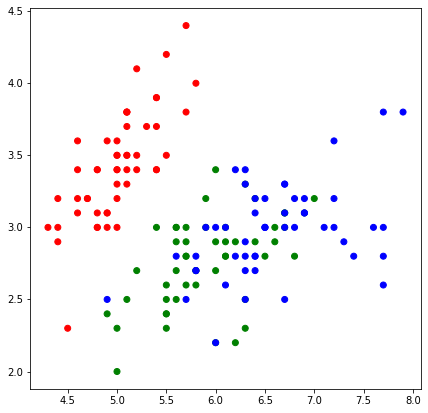

In [53]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

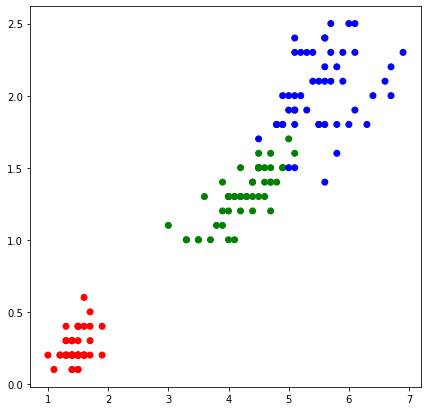

In [54]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 2], X[:, 3], c=y, cmap=cmap);